# Avance 3 — Baseline (Predictor de Escalamiento)


**Objetivo:** establecer un modelo de referencia para `continue` / `clarify` / `handoff` y responder a la rúbrica:
- Algoritmo baseline y justificación
- Métricas y sub/sobreajuste (learning curve)
- Importancia de características
- Desempeño mínimo frente a un baseline ingenuo


## 0) Carga de datos

In [9]:

import pandas as pd, numpy as np
CSV = r"generated_converted.csv"
df = pd.read_csv(CSV)
df['final_label'] = df['final_label'].astype(str).str.strip()
df['user_text'] = df['user_text'].fillna("")
print("Shape:", df.shape)
df.head(3)


Shape: (161, 20)


,conv_id,turn_id,user_text,bot_text,lang,domain,tool_available,tool_error,tool_timeout,n_reprompts_similar,confidence_sim,intent_margin_sim,has_dates,has_money,has_url,imperative_flag,wh_flag,topic_risky,final_label,timestamp
0,c_001,1,Quiero reservar un vuelo a Cancún para la próx...,"Claro, ¿para cuántos pasajeros y qué fechas ex...",es,reservas,1,0,0,0,0.72,0.31,1,0,0,1,0,0,clarify,2025-10-02T18:00:00Z
1,c_001,2,"para 2 adultos, del 10 al 15 de oct","Perfecto, buscando vuelos para 2 adultos a Can...",es,reservas,1,0,0,0,0.98,0.75,1,0,0,0,0,0,continue,2025-10-02T18:00:45Z
2,c_002,1,How much is the total for my cart? Include taxes.,"Your cart total is $1,450.50 USD, including a ...",en,calculo,1,0,0,0,0.95,0.60,0,0,0,0,1,0,continue,2025-10-02T18:01:10Z


## 0.1) Variables clave y densas derivadas

In [10]:

target = 'final_label'
text_col = 'user_text'
dense_cols = [
    'n_reprompts_similar','tool_error','tool_timeout',
    'confidence_sim','intent_margin_sim',
    'has_dates','has_money','has_url','imperative_flag','wh_flag','topic_risky','tool_available'
]
for c in dense_cols:
    if c not in df.columns: df[c] = 0

import numpy as np, pandas as pd
def build_dense(frame):
    s = frame[text_col].fillna("")
    words = s.str.split()
    D = pd.DataFrame({
        'len_chars_user': s.str.len(),
        'len_words_user': words.apply(len),
        'question_marks': s.str.count(r'\?'),
        'exclam_marks': s.str.count(r'!'),
        'n_reprompts_similar': frame['n_reprompts_similar'].fillna(0).astype(float),
        'tool_error': frame['tool_error'].fillna(0).astype(float),
        'tool_timeout': frame['tool_timeout'].fillna(0).astype(float),
        'confidence_sim': frame['confidence_sim'].fillna(0.0).astype(float),
        'intent_margin_sim': frame['intent_margin_sim'].fillna(0.0).astype(float),
        'has_dates': frame['has_dates'].fillna(0).astype(int),
        'has_money': frame['has_money'].fillna(0).astype(int),
        'has_url': frame['has_url'].fillna(0).astype(int),
        'imperative_flag': frame['imperative_flag'].fillna(0).astype(int),
        'wh_flag': frame['wh_flag'].fillna(0).astype(int),
        'topic_risky': frame['topic_risky'].fillna(0).astype(int),
        'tool_available': frame['tool_available'].fillna(0).astype(int),
    })
    D['len_chars_user'] = np.log1p(D['len_chars_user'])
    D['len_words_user'] = np.log1p(D['len_words_user'])
    D['n_reprompts_similar'] = np.log1p(D['n_reprompts_similar'])
    return D

dense_derived = build_dense(df)
dense_derived.head(3)


,len_chars_user,len_words_user,question_marks,exclam_marks,n_reprompts_similar,tool_error,tool_timeout,confidence_sim,intent_margin_sim,has_dates,has_money,has_url,imperative_flag,wh_flag,topic_risky,tool_available
0,4.043051,2.397895,0,0,0.0,0.0,0.0,0.72,0.31,1,0,0,1,0,0,1
1,3.583519,2.302585,0,0,0.0,0.0,0.0,0.98,0.75,1,0,0,0,0,0,1
2,3.912023,2.397895,1,0,0.0,0.0,0.0,0.95,0.60,0,0,0,0,1,0,1


## 1) Split train/test

In [11]:

from sklearn.model_selection import train_test_split
X_text = df[text_col]
X_num  = dense_derived
y = df[target]
X_text_tr, X_text_te, X_num_tr, X_num_te, y_tr, y_te = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42, stratify=y
)
X_text_tr.shape, X_num_tr.shape


((128,), (128, 16))

## 2) Baselines (Dummy y LogReg OvR)

In [12]:

from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

dummy = DummyClassifier(strategy='most_frequent').fit(
    pd.DataFrame({'a': [0]*len(y_tr)}), y_tr
)
y_hat_te_dummy = dummy.predict(pd.DataFrame({'a':[0]*len(y_te)}))
print("Dummy F1 macro (test):", round(f1_score(y_te, y_hat_te_dummy, average='macro'),3))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np

tfidf_word = TfidfVectorizer(ngram_range=(1,2), min_df=1, strip_accents='unicode', lowercase=True, max_features=20000)
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=1, lowercase=True, max_features=8000)

def make_X(text_series, num_df):
    return np.column_stack([text_series.values, num_df.values])

X_tr = make_X(X_text_tr, X_num_tr)
X_te = make_X(X_text_te, X_num_te)

pre = ColumnTransformer([
    ('word', tfidf_word, 0),
    ('char', tfidf_char, 0),
    ('num',  StandardScaler(with_mean=True), slice(1, None)),
], verbose_feature_names_out=False)

pipe = Pipeline([('pre', pre),
                 ('clf', LogisticRegression(max_iter=600, class_weight='balanced', multi_class='ovr'))])

pipe.fit(X_tr, y_tr)
y_hat_te = pipe.predict(X_te)
print("LogReg F1 macro (test):", round(f1_score(y_te, y_hat_te, average='macro'),3))
print(classification_report(y_te, y_hat_te, digits=3))
cm = confusion_matrix(y_te, y_hat_te, labels=sorted(y.unique()))
cm


Dummy F1 macro (test): 0.208
LogReg F1 macro (test): 0.971
              precision    recall  f1-score   support

     clarify      0.900     1.000     0.947         9
    continue      1.000     0.933     0.966        15
     handoff      1.000     1.000     1.000         9

    accuracy                          0.970        33
   macro avg      0.967     0.978     0.971        33
weighted avg      0.973     0.970     0.970        33



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


array([[ 9,  0,  0],
       [ 1, 14,  0],
       [ 0,  0,  9]])

## 3) Learning curve (sub/sobreajuste)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Admin\AppD

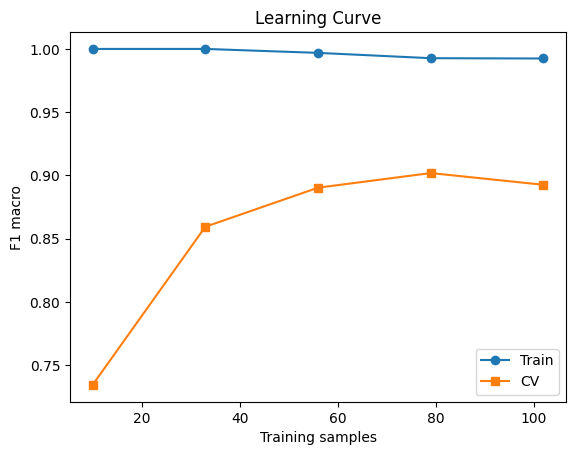

In [13]:

from sklearn.model_selection import learning_curve
import numpy as np, matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    pipe, X_tr, y_tr, cv=5, scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)
fig = plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='s', label='CV')
plt.xlabel('Training samples'); plt.ylabel('F1 macro'); plt.title('Learning Curve')
plt.legend(); plt.show()


## 4) Importancia de características

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


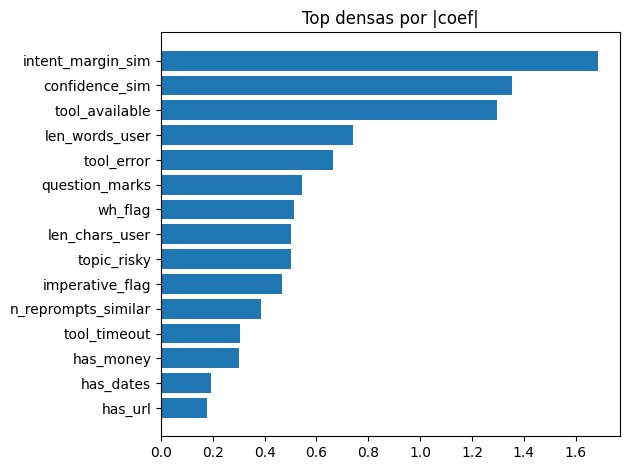

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


,neg,pos
ajsdkfhasdkljf,-0.257667,NaN
cuenta,-0.267420,NaN
dont,NaN,0.409848
dont know,NaN,0.409848
el,-0.277397,NaN
extrae,-0.293245,NaN
factura,-0.291106,NaN
failed,NaN,0.389000
from,-0.308152,NaN
hablar,NaN,0.696455


In [14]:
from sklearn.pipeline import make_pipeline
num_only = make_pipeline(StandardScaler(with_mean=True),
                         LogisticRegression(max_iter=600, class_weight='balanced', multi_class='ovr'))
num_only.fit(X_num_tr, y_tr)
coef = num_only.named_steps['logisticregression'].coef_
dense_names = list(X_num_tr.columns)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
imp_num = pd.Series(np.mean(np.abs(coef), axis=0), index=dense_names).sort_values(ascending=False)

fig = plt.figure()
plt.barh(range(15), imp_num.head(15).values[::-1])
plt.yticks(range(15), imp_num.head(15).index[::-1])
plt.title('Top densas por |coef|')
plt.tight_layout(); plt.show()

text_only = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=1, strip_accents='unicode', lowercase=True, max_features=20000)),
                      ('lr', LogisticRegression(max_iter=600, class_weight='balanced', multi_class='ovr'))]).fit(X_text_tr, y_tr)
vocab = text_only.named_steps['tfidf'].get_feature_names_out()
coef = text_only.named_steps['lr'].coef_
classes = text_only.named_steps['lr'].classes_

def top_tokens(coef, classes, vocab, topn=15):
    tables = {}
    for i, cls in enumerate(classes):
        w = pd.Series(coef[i], index=vocab).sort_values()
        tables[cls] = {'neg': w.head(topn), 'pos': w.tail(topn)[::-1]}
    return tables

tables = top_tokens(coef, classes, vocab, topn=15)
cls = 'handoff' if 'handoff' in tables else list(tables.keys())[0]
pd.DataFrame(tables[cls])


## 5) Conclusiones

La curva muestra modelo con bajo sesgo y ligera varianza; con el set actual ya rinde alto (CV≈0.90).

Acciones: más datos y un toque más de regularización/compresión de texto para estabilizar.

El baseline supera claramente al Dummy y es una base sólida para el siguiente avance.
